<a href="https://colab.research.google.com/github/Keenandrea/sentiment/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

# User Sentiment

---

This Colabook will explore words and their ability to define sentiment. Sentiment is easier displayed in-person than interpreted through text. One challenge that rears its ugly head into the constant digital messaging of our modern communication is how to recognize the sentiment of someone using this form of communication. Many approaches have been taken, in recent years, emails have included exclamation points instead of periods because the exclamation point, although originally used as a device to exclaim, looks much friendlier than a full-stop period. Emojis are another valuable method of sentiment communication between texts. That being said, wouldn't it be nice to receive a text message full of words and words alone, a text message that could be translated as facetious, sarcastic, rude, or coy joking, depending on which way the receiver interpreted it, and immediately, if confused, have an app that scans the message and returns the correct sentiment of the sender? Although this project does not cover the all-encompassing spectrum of human sentiment, we'll be employing methods of binary classification on a large dataset of tweets from multiple different users to determine whether that user's tweet was of positive or negative sentiment.

---






---

## De Rigueur Libraries

---



In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gensim

import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.regularizers import L1L2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-white')



---






---

## Kaggle Meets Colab

---

Want to access Kaggle data from Colab? Course you do. So: login to Kaggle. Next tab to: [ your profile -> my account -> more -> account -> create new API token ]. And one kaggle.json should start downloading. Then: 

Open kaggle.json. Copy "YOUR_USERNAME" and ”SOME-BETY-BETY-LONG-STRING” from line { “username” : ”YOUR-USER-NAME”, ”key” : ”SOME-BETY-BETY-LONG-STRING” }. Paste each according to the cell below: 

---



In [0]:
os.environ['KAGGLE_USERNAME'] = "keenandrea"
os.environ['KAGGLE_KEY'] = "df347d3b581e5cad8bda11ebdd72e9bb"



---

Presto. You've got all the kaggle datasets neatly before you. Seeing is believing? Sure. Run the cell below:

---



In [0]:
!kaggle datasets list -s sentiment

ref                                                    title                                          size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
crowdflower/twitter-airline-sentiment                  Twitter US Airline Sentiment                    3MB  2019-10-16 00:04:05          33061  
harriken/emoji-sentiment                               Emoji sentiment                                12MB  2017-10-01 09:56:54           2197  
bittlingmayer/amazonreviews                            Amazon Reviews for Sentiment Analysis         493MB  2019-11-18 02:50:34          19116  
kazanova/sentiment140                                  Sentiment140 dataset with 1.6 million tweets   81MB  2017-09-13 22:43:19          20951  
crowdflower/first-gop-debate-twitter-sentiment         First GOP Debate Twitter Sentiment              2MB  2019-11-17 21:18:37   



---

Now: shop the dataset you want. Once that dataset** is found, run command !kaggle datasets download -d NAME_OF_YOUR_DESIRED_DATASET -p /content. For instance, I want kazanova/sentiment140. That's point [1,4] on the list above, which is column one, row four. That's what I want. This is how I get it:

**[Footnote]: alternatively, run !kaggle datasets list, to display the whole kit-and-kaboodle. What you see one cell up is a filtering option to search kaggle datasets with substring [-s] sentiment [sentiment].  

---



In [3]:
!kaggle datasets download -d kazanova/sentiment140 -p /content

 96% 78.0M/80.9M [00:02<00:00, 24.9MB/s]
100% 80.9M/80.9M [00:02<00:00, 28.6MB/s]




---

Last things last, you've got to unzip the dataset, and then turn it loose on your Colabook. Easy peasy.

---



In [0]:
!unzip -q sentiment140.zip



---






---

# Tweet Sentiment

---

In this next part we're going to parse, clean, embed, analyze, train, and obtain sentiment predictions for the *sentiment140* kaggle dataset using the most frequent words in the text corpus as feature columns.

---





---

### Input Features

---

There are six feature columns in the twitter sentiment dataset. The tweets are cut evenly down the middle. Half of them are of positive sentiment, the other half negative. The sentiment dataset was pulled from Kaggle through a colab notebook. The dataset was made of six feature columns, that is: 'label', 'id', 'date', 'flag', 'user', and 'text'. To clear the fluff, we'll remove three feature columns that contribute very little to our purpose, namely: id, flag, and user. Id is tacit upon creating our Pandas dataframe, flag is the query, user is needless since we aren't considering who authored the tweet, and, finally, date is of little care to us as well, since we will not be attempting any time-series analysis. The only two feature columns truly necessary for our purpose are label and text as our example input-output pairs for our supervised learning task. 

---




In [0]:
tweet_file = 'training.1600000.processed.noemoticon.csv'
cleaning = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
features = ['label','id','date','flag','user','text']
encoding = 'ISO-8859-1'

In [7]:
df = pd.read_csv(tweet_file,names=features,encoding=encoding)
df.head(2)

,label,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School to...


In [8]:
print('Dataset size of',df.shape[0],'rows and',df.shape[1],'columns')

Dataset size of 1600000 rows and 6 columns




---

## Reducing Input Features

---

### Dropping Feature Columns

---






---

To clear the fluff, we'll remove three feature columns that contribute very little to our purpose, namely: id, flag, and user. Id is tacit upon creating our Pandas dataframe, flag is the query, user is needless since we aren't considering who authored the tweet, and, finally, date is of little care to us as well, since we will not be attempting any time-series analysis. The only two feature columns truly necessary for our purpose are label and text as our example input-output pairs for our supervised learning task.

---



In [9]:
df = df.drop(columns=['id','date','flag','user'])
df.head(2)

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Thi..."
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School to...




---

## Feature Importance

---

### Importance of Label Column

---

Our label column is binary. Rows with 0 indicate tweets with negative sentiment, while rows with 4 indicate tweets with positive sentiment. This feature column is important because it gives face to the binary classification problem our model will be facing.


The plot below shows the label feature column of our dataframe is split evenly between tweets recognized as positive, and tweets recognized as negative. 

---




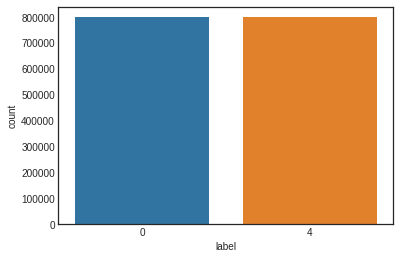

In [10]:
sns.countplot(x='label',data=df)



---

### Importance of Text Column

---

The text feature column is tricky. It's the only input column we both have and need to perform our binary classification. The obstacle deals with somehow withdrawing the important features from the text feature column and employing them for a model that is able to predict tweet sentiment given a set of words. 

---





---

The most frequent words do not matter much with regard to user sentiment. Many of them are grammatical need-bes placed within the text to signify other, more important parts of speech that do express sentiment, such as nouns, adjectives, and verbs.

---





---

The solution here is to remove those frivolities. We'll use nltk's stopwords function to do this. The function contains a pre-defined list of English words that would be considered under our umbrella of frivolities.

---



In [11]:
nltk.download('stopwords')
stop_words=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.




---

### Cleaning The Tweets

---

Next we'll want to reduce the extraneous characters over-crowding the language used in each tweet, thereby allowing the model an easier go at identifying sentiment. Mentions, or, tagging a user in a post with the @ character exemplifies the type of foofaraw we'll be removing. Not only that, but we'll also remove https://, or, hyperlinks from our feature column, among other things, to ensure, as stated, that any noise our model may encounter when embedding and analyzing the content of a tweet is reduced as much as we can possibly reduce it.

---



In [0]:
corpus=[]
for i in range(0,len(df)):
    review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',df['text'][i])
    review=review.lower()
    review=review.split()
    review=[word for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

In [0]:
df.text=corpus

In [0]:
df.head(2)

,label,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result school today also blah


In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [45]:
df.head()

,label,good,day,like,today,work,love,lol,time,know,really,see,night,still,well,new,want,think,home,thanks,oh,much,miss,need,feel,hope
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0




---

We replace all the 4s in our label column with 1s, to have it represent something more binarily classifiable.

---



In [0]:
df.label.replace({4:1},inplace=True)



---

We'll create an array of our choice words. These words are in the top-75 most frequent of our text corpus, after the text was cleaned and the stopwords removed. 

---



In [0]:
top_25 = ['good','day','like','today','work',
          'love','lol','time','know','really',
          'see','night','still','well','new',
          'want','think','home','thanks','oh',
          'much','miss','need','feel','hope',
          'back','haha','feel','sad','fun',
          'wish','sleep','right','bad','would',
          'happy','sorry','tonight','come','make',
          'though','nice','better','watching','yeah',
          'wait','bed','week','school','people']



---

Word by word, we'll create feature columns that contain the count of each word in each tweet.

---



In [0]:
def word_frequency(word):
  df[word] = df['text'].str.count(word)

for i in range(0,25,1):
  word_frequency(top_25[i])

df = df.drop(columns=['text'])




---

Word embeddings are vector representations of any particular word. The technique we'll use to embed our tweets'll be a popular one known as Word2Vec. First we'll declare parameters for the Word2Vec model, then we'll build the model, train the model, and lastly run some tests on the results to see if we have what we want from the model.

---



In [0]:
documents = [text.split() for text in train.text]

In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Size of model vocab:", vocab_size)

Size of model vocab: 30413


In [0]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(246692269, 276798180)



---

Now, with the model trained, we'll use gensim's most_similar function to find the top-N most similar words. Positive words will contribute positively towards the similarity, negative words contribute negatively. We'll pass this function to a few of the most frequent words in our tweet feature column that will shortly be converted into individual feature columns, appended to the dataframe, and reviewed to assist predictions.

---





---

Our Word2Vec model is making some fairly accurate similarity predictions of a word. What this tells us is that our words have been embedded. 

---



In [0]:
w2v_model.wv.most_similar("day")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('weekend', 0.6777357459068298),
 ('week', 0.6125987768173218),
 ('time', 0.5857556462287903),
 ('dayy', 0.5758532881736755),
 ('morning', 0.5317856073379517),
 ('today', 0.5113763213157654),
 ('sunday', 0.5012823939323425),
 ('evening', 0.495885968208313),
 ('night', 0.49416500329971313),
 ('afternoon', 0.4936937987804413)]

In [0]:
w2v_model.wv.most_similar("like")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('liek', 0.48944374918937683),
 ('weird', 0.4865761399269104),
 ('bad', 0.43718475103378296),
 ('stalkerish', 0.4228995740413666),
 ('inadequate', 0.41016289591789246),
 ('better', 0.408244252204895),
 ('lik', 0.40413233637809753),
 ('unloved', 0.4005945920944214),
 ('familiar', 0.39740145206451416),
 ('helpless', 0.38819360733032227)]

In [0]:
w2v_model.wv.most_similar("oh")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ohh', 0.5547873973846436),
 ('ohhh', 0.5268933773040771),
 ('ah', 0.49437540769577026),
 ('ohhhh', 0.4882204532623291),
 ('aw', 0.4176540970802307),
 ('ahh', 0.38989633321762085),
 ('oooh', 0.38025906682014465),
 ('fargo', 0.3794403672218323),
 ('nuh', 0.35429030656814575),
 ('sakes', 0.35300877690315247)]

In [0]:
w2v_model.wv.most_similar("lol")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('lmao', 0.7650360465049744),
 ('haha', 0.7491662502288818),
 ('hahaha', 0.6460617184638977),
 ('u', 0.5969237089157104),
 ('hehe', 0.5581870675086975),
 ('cuz', 0.5430053472518921),
 ('lmfao', 0.5379681587219238),
 ('hahah', 0.5165081024169922),
 ('yea', 0.5041918754577637),
 ('lmaoo', 0.49686700105667114)]

In [0]:
w2v_model.wv.most_similar("miss")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('misses', 0.6024397611618042),
 ('missing', 0.5952507257461548),
 ('missin', 0.5479378700256348),
 ('misss', 0.47836437821388245),
 ('love', 0.4175484776496887),
 ('misssss', 0.3966166079044342),
 ('missss', 0.3932454586029053),
 ('fun', 0.3825644254684448),
 ('leaving', 0.3809747099876404),
 ('homesick', 0.37619727849960327)]

In [0]:
w2v_model.wv.most_similar("need")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('needs', 0.7002875804901123),
 ('want', 0.6106590628623962),
 ('needa', 0.539360761642456),
 ('gotta', 0.5235423445701599),
 ('trying', 0.5206313133239746),
 ('wanna', 0.4795724153518677),
 ('wants', 0.4718064069747925),
 ('needing', 0.45453277230262756),
 ('wanting', 0.4053877592086792),
 ('tryin', 0.3966308534145355)]



---

Once a list of the most frequent words in our text corpus has been selected by those words that seem most interesting to our purpose, we'll make out of each word a feature column whose rows contain the frequency count of that word in the text of each tweet.

---



In [0]:
plt.hist(x_train.iloc[:,0])
plt.ylabel('good')
plt.show()

plt.hist(x_train.iloc[:,1])
plt.ylabel('day')
plt.show()

plt.hist(x_train.iloc[:,2])
plt.ylabel('like')
plt.show()

plt.hist(x_train.iloc[:,3])
plt.ylabel('today')
plt.show()

plt.hist(x_train.iloc[:,4])
plt.ylabel('work')
plt.show()

plt.hist(x_train.iloc[:,5])
plt.ylabel('love')
plt.show()

plt.hist(x_train.iloc[:,6])
plt.ylabel('lol')
plt.show()

plt.hist(x_train.iloc[:,7])
plt.ylabel('time')
plt.show()

plt.hist(x_train.iloc[:,8])
plt.ylabel('know')
plt.show()

plt.hist(x_train.iloc[:,9])
plt.ylabel('really')
plt.show()

plt.hist(x_train.iloc[:,10])
plt.ylabel('see')
plt.show()

plt.hist(x_train.iloc[:,11])
plt.ylabel('night')
plt.show()

plt.hist(x_train.iloc[:,12])
plt.ylabel('still')
plt.show()

plt.hist(x_train.iloc[:,13])
plt.ylabel('well')
plt.show()

plt.hist(x_train.iloc[:,14])
plt.ylabel('new')
plt.show()

plt.hist(x_train.iloc[:,15])
plt.ylabel('want')
plt.show()

In [0]:
plt.hist(x_validate.iloc[:,0])
plt.ylabel('good')
plt.show()

plt.hist(x_validate.iloc[:,1])
plt.ylabel('day')
plt.show()

plt.hist(x_validate.iloc[:,2])
plt.ylabel('like')
plt.show()

plt.hist(x_validate.iloc[:,3])
plt.ylabel('today')
plt.show()

plt.hist(x_validate.iloc[:,4])
plt.ylabel('work')
plt.show()

plt.hist(x_validate.iloc[:,5])
plt.ylabel('love')
plt.show()

plt.hist(x_validate.iloc[:,6])
plt.ylabel('lol')
plt.show()

plt.hist(x_validate.iloc[:,7])
plt.ylabel('time')
plt.show()

plt.hist(x_validate.iloc[:,8])
plt.ylabel('know')
plt.show()

plt.hist(x_validate.iloc[:,9])
plt.ylabel('really')
plt.show()

plt.hist(x_validate.iloc[:,10])
plt.ylabel('see')
plt.show()

plt.hist(x_validate.iloc[:,11])
plt.ylabel('night')
plt.show()

plt.hist(x_validate.iloc[:,12])
plt.ylabel('still')
plt.show()

plt.hist(x_validate.iloc[:,13])
plt.ylabel('well')
plt.show()

plt.hist(x_validate.iloc[:,14])
plt.ylabel('new')
plt.show()

plt.hist(x_validate.iloc[:,15])
plt.ylabel('want')
plt.show()



---

The dataframe is split between train, test, and validate sets.

---



In [0]:
x_validate = df.iloc[:240000,1:26]
y_validate = df.iloc[:240000,0]

x_train = df.iloc[240000:1200000,1:26]
y_train = df.iloc[240000:1200000,0]

x_test = df.iloc[1200000:,1:26]
y_test = df.iloc[1200000:,0]



---

The train and validate sets are normalized.

---



In [0]:
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train_norm = std_scale.transform(x_train)
training_norm_col = pd.DataFrame(x_train_norm, index=x_train.index, columns=x_train.columns) 
x_train.update(training_norm_col)

In [0]:
x_train.head()

In [0]:
std_scale = preprocessing.StandardScaler().fit(x_validate)
x_validate_norm = std_scale.transform(x_validate)
validate_norm_col = pd.DataFrame(x_validate_norm, index=x_validate.index, columns=x_validate.columns) 
x_validate.update(validate_norm_col)

In [0]:
x_validate.head()



---

### Linear Regression Model

---

To compare Linear Regression model applications against Logistic Regression applications, we'll use sklean's Linear and Logistic Regression built-in models and evaluate them by R-squared and RMSE metrics.

---



In [0]:
from sklearn.linear_model import LinearRegression
lin_regression = LinearRegression()
_ = lin_regression.fit(pd.DataFrame(x_train),y_train)
lin_y_pred_1 = lin_regression.predict(pd.DataFrame(x_train))

In [72]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_validate)
acc_log = round(linreg.score(x_train, y_train) * 100, 2)
acc_log

7.25



---

### Logistic Regression Model

---



In [0]:
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression(solver='lbfgs')
_ = log_regression.fit(pd.DataFrame(x_train),y_train)
y_pred = log_regression.predict_proba(pd.DataFrame(x_train))
log_y_pred_1 = [item[1] for item in y_pred]

In [73]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_validate)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


58.73



---

## Accuracy Metrics

---



In [52]:
from sklearn.metrics import mean_squared_error, r2_score
print("Linear Regression R2:",r2_score(y_train,lin_y_pred_1))
print("Logistic Regression R2:",r2_score(y_train,log_y_pred_1))
print("Linear Regression RMSE: ", mean_squared_error(y_train, lin_y_pred_1))
print("Logistic Regression RMSE: ", mean_squared_error(y_train, log_y_pred_1))

Linear Regression R2: 0.072545906166119
Logistic Regression R2: 0.07540952582770022
Linear Regression RMSE:  0.23186328771445316
Logistic Regression RMSE:  0.23114738352694428


In [74]:
model = Sequential()  
model.add(Dense(64,input_dim=25,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 6,353
Trainable params: 6,353
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train, epochs=15, batch_size=100, validation_data=(x_validate, y_validate))



---

Evaluating the model on the training data gives us the following results.

---



In [57]:
scores = model.evaluate(x_train, y_train)
print(model.metrics_names)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

960000/960000 [==============================] - 48s 51us/step
['loss', 'acc']
[0.6491343979736169, 0.5910583333333334]

acc: 59.11%



---

Evaluating the model on the validation data gives us the following results.

---

In [59]:
scores = model.evaluate(x_validate, y_validate)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

240000/240000 [==============================] - 12s 50us/step

acc: 59.10%


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
prediction = model.predict(x_validate)
accuracy = accuracy_score(y_validate, prediction.round())
precision = precision_score(y_validate, prediction.round())
recall = recall_score(y_validate, prediction.round())
f1score = f1_score(y_validate, prediction.round())
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1score))

Accuracy: 59.10%
Precision: 56.47%
Recall: 80.40%
F1-score: 0.66




---

## Machine Learning Algorithms

---

A last ditch effort. We'll move away from deep learning and revert to machine learning, leveraging several algorithms for our purpose to see if these outperform our network architectures.

---




In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier



---

### Support Vector Machines

---



In [0]:
svc = SVC()
svc.fit(x_train, y_train)
Y_pred = svc.predict(x_validate)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

---

### k-Nearest Neighbors

---

In [0]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_pred = knn.predict(x_validate)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
acc_knn



---

### Gaussian Naive Bayes

---



In [0]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_validate)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
acc_gaussian

---

### Perceptron

---

In [0]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)
Y_pred = perceptron.predict(x_validate)
acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
acc_perceptron

---

### Linear Support Vector Machines

---

In [0]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

---

### Stochastic Gradient Descent

---

In [0]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
Y_pred = sgd.predict(x_validate)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
acc_sgd

---

### Decision Tree

---

In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_validate)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

---

### Random Forest

---

In [0]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_validate)
random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
acc_random_forest

---

### Comparative Evaluation

---

In [0]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)



---

Let's check this out. Let's evaluate. Accuracy, for starters, is not good. Just 9 percent above half right, half wrong. Precision, which refers to the percentage of model results that are relevent, is less. Fifty-six percent of our model results are relevent. No good. Recall, at eighty percent, which refers to the percentage of total relevant results correcly classified by the model, isn't bad, however, considering eighty percent of fifty-six percent of results were correctly classified, it seems nonsensical as well. Finally, F1-score, which, in a nutshell is the measure of our model's accuracy, is 0.66. Evaluation? Words alone, at least the amount we have here, and their frequency within a text corpus, are not enough to predict sentiment.

---





---

# Future Considerations

---

Thing is, this is quite an unorthodox approach to solving the text sentiment problem. Most approaches use word embeddings, similar to those discussed earlier. Since ours is a novel approach to the problem, it's moreso experimentation to see whether a new approach will better solve the problem, and, in this case, this sadly is not a better way. 

We could've seen this coming. From the word embeddings above, it's apparent that one word, such as 'lol' or 'happy' is not the only case to be evaluated. Rather, a word like 'lol' has counterpart words, according to the Word2Vec similarity, such as 'lmao', 'haha', 'hahaha', 'hha', 'hahhah', 'hehe', 'lmfao', 'rofl', 'lolol', 'lmaoo', and many, many others. That's the problem. People do not text with grammatical accuracy. Which leads us to believe, in order to properly define sentiment using a word, we must include all similar cases of that word under one umbrella, a sort of joining together of all similar usage will increase the low number of occurrences in our text corpus and hopefully give the model better predicative capability. 

---


